# Random Forest Classifier

###### https://en.wikipedia.org/wiki/Random_forest
###### Please refer the above link for details on Random Forest Classifier

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import os as os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# Set working dierctory
os.chdir("..")
cwd = os.getcwd()
os.chdir(f'{cwd}\\Data\\Model data\\')

In [3]:
# Read the dataset
data = pd.read_csv("Final_model_dataset.csv")

In [4]:
# Set the FIPS variable as index
data = data.set_index("FIPS")

## Required functions for this model

In [5]:
# Initial Variable reduction using GBM variable importance
def Variable_Reduction(X_train, independent_vars, y_train):
    X = X_train[independent_vars]
    y = y_train
    clf = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=4, min_samples_split=0.05, 
                                 max_features='sqrt', n_jobs=-1, random_state=12345)
    clf.fit(X,y)
    VarSel = pd.DataFrame(independent_vars)
    VarSel.columns = ["Variables"]
    VarSel["Importance"] = (clf.feature_importances_)
    return VarSel

In [6]:
def Drop_one_var(X_train, independent_vars, y_train):
    VarSel = Variable_Reduction(X_train, independent_vars, y_train)
    VarSel = VarSel.sort_values(["Importance"], ascending=False)
    min_imp = VarSel["Importance"].min()
    VarSel = VarSel[VarSel["Importance"]> min_imp]
    return list(VarSel["Variables"])

In [7]:
def KS_Table(dataset):
    tmp_df = dataset.copy()
    tmp_df['bin'] = pd.qcut(tmp_df["Prob"], q=10, duplicates='drop')
    tmp1 = (tmp_df.groupby("bin").count()).drop("Prob",axis=1)
    tmp2 = (tmp_df.groupby("bin").sum()).drop("Prob",axis=1)
    tmp3 = (tmp_df.groupby("bin").mean()).drop("y",axis=1)
    tmp1.columns = ["Total"]
    tmp2.columns = ["Goods"]
    tmp3.columns = ["PredRR"]
    tmp = tmp1.merge(tmp2, how="outer", left_index=True, right_index=True)
    tmp = tmp.merge(tmp3, how="outer", left_index=True, right_index=True)
    tmp = tmp.sort_values("PredRR", ascending=False)
    tmp["ObsRR"] = tmp["Goods"]/tmp["Total"]
    tmp["Bads"] = tmp["Total"] - tmp["Goods"]
    tmp["Perct_Goods"] = tmp["Goods"]/tmp["Goods"].sum()
    tmp["Perct_Bads"] = tmp["Bads"]/tmp["Bads"].sum()
    tmp["Cum_Perct_Goods"] = tmp["Perct_Goods"].cumsum()
    tmp["Cum_Perct_Bads"] = tmp["Perct_Bads"].cumsum()
    tmp["KS"] = np.round(tmp["Cum_Perct_Goods"] - tmp["Cum_Perct_Bads"],3)*100
    return tmp

In [8]:
def Iter_RF_HyperParam(X_train, y_train, X_test, y_test, independent_vars, NTrees, Depth):
    X1 = X_train[independent_vars]
    y = y_train.ravel()
    clf = RandomForestClassifier(n_estimators=NTrees, criterion='gini', max_depth=Depth, min_samples_split=0.05,
                                 max_features='sqrt', n_jobs=-1, random_state=12345)
    clf.fit(X1,y)
    # Performance on train sample
    y_hat = clf.predict_proba(X1)
    results_train = pd.DataFrame()
    results_train["Prob"] = (y_hat[: ][: , 1])
    results_train["y"] = y_train.ravel()
    KS_Train_met = KS_Table(results_train)["KS"].max()
    
    #Performance on test sample
    X2 = X_test[independent_vars]
    y_hat = clf.predict_proba(X2)
    results_test = pd.DataFrame()
    results_test["Prob"] = (y_hat[: ][: , 1])
    results_test["y"] = y_test.ravel()
    KS_Test_met = KS_Table(results_test)["KS"].max()
    
    return KS_Train_met, KS_Test_met

### As the initial set of variables is really high (10,000+), we shall pick only the top variables based on Information value (IV).
### IV was calculated in Logistic Regression model, and hence shall read the same csv file to save resources

In [9]:
# Read IV file
IV_table = pd.read_csv("Information_Value.csv")

In [10]:
# Put a cut-off of IV>0.10
IV_table = IV_table[IV_table["IV"]>0.10]

In [11]:
Initial_Variables = list(IV_table["Variables"])
Initial_Variables.remove("Mortality_change_2012_2014")

### Feature scaling and PCA to reduce feature set

In [12]:
# Standardizing the features
X = data[Initial_Variables]
StdSclr = StandardScaler().fit(X)
X1 = StdSclr.transform(X)

In [13]:
# PCA transformation
pca = PCA(n_components=20)
pcafit = pca.fit(X1)
pricipalComponents = pcafit.transform(X1)

In [14]:
# Convert the Principal Components into a pandas dataframe
arr = list(np.arange(0,20,1))
colnames = [("PCA_"+str(ar)) for ar in arr]
principalDf = pd.DataFrame(data = pricipalComponents, columns = colnames)
principalDf.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19
0,30.800210,-0.080506,-19.539556,-0.521350,-4.892962,10.687493,-4.427965,-0.226236,1.437680,1.142740,1.398549,-3.349617,-1.352431,-2.151252,0.662332,3.573884,-4.405661,5.235859,4.496214,0.433358
1,12.740122,10.938975,3.637980,-4.474000,-0.578941,-0.353140,-5.299740,-2.149521,4.546508,1.168549,0.804263,-10.136153,1.518292,3.725788,-6.935428,2.905513,-2.771512,3.486802,3.791474,-1.187395
2,39.124687,-4.440052,-0.806659,14.784193,-9.635509,-3.036066,-4.898818,2.744003,-2.873642,-0.837795,-7.232772,-2.673453,-5.154757,1.509020,-6.775999,0.517019,-8.748939,0.931348,2.852725,6.831228
3,41.827004,-5.801363,-14.667366,9.847788,-7.560088,11.980695,-2.048175,-4.252003,-5.715849,-5.598671,-8.055203,1.673604,-0.945584,-2.294616,-4.465602,1.329520,-7.932116,3.101844,0.190426,2.354610
4,24.219103,-3.018081,-9.340286,-2.979836,-3.470174,8.440551,-2.191821,-7.379515,4.609515,-6.045886,-0.509902,2.351587,5.192258,-1.261657,3.257621,-1.167605,-3.120315,1.743900,0.850182,1.446764


## Selecting the model

In [15]:
# Split the data in train and test
X_train, X_test, y_train, y_test = train_test_split(principalDf, data["Target"], test_size=0.33, random_state=12345)

In [16]:
initial_vars = list(principalDf.columns)

In [17]:
NTrees = [50, 100]
Depth = [2,3,4]
expected_length = (len(NTrees)*len(Depth)*len(initial_vars))
KS_Train = [None]*expected_length
KS_Test = [None]*expected_length
NTrees_met = [None]*expected_length
Depth_met = [None]*expected_length
No_Vars = [None]*expected_length

In [18]:
ite = 0
while(len(initial_vars)>5):
    for i in range(0, len(NTrees)):
        for j in range(0, len(Depth)):
            NTrees_met[ite] = NTrees[i]
            Depth_met[ite] = Depth[j]
            No_Vars[ite] = len(initial_vars)
            KS_Train[ite], KS_Test[ite] = Iter_RF_HyperParam(X_train,y_train, X_test, y_test, initial_vars, 
                                                             NTrees[i], Depth[j])
            ite += 1
    initial_vars = Drop_one_var(X_train, initial_vars, y_train)
    pd.DataFrame(initial_vars).to_csv("RF_"+str(len(initial_vars))+".csv")

In [19]:
results = pd.DataFrame()
results["No_Vars"] = No_Vars[0:ite]
results["NTrees_met"] = NTrees_met[0:ite]
results["Depth_met"] = Depth_met[0:ite]
results["KS_Train"] = KS_Train[0:ite]
results["KS_Test"] = KS_Test[0:ite]

In [20]:
print(results.to_string())

    No_Vars  NTrees_met  Depth_met  KS_Train  KS_Test
0        20          50          2      47.9     47.7
1        20          50          3      49.5     49.0
2        20          50          4      54.8     46.3
3        20         100          2      45.7     47.8
4        20         100          3      50.2     51.0
5        20         100          4      52.7     50.3
6        19          50          2      45.4     45.0
7        19          50          3      50.8     49.0
8        19          50          4      53.6     49.6
9        19         100          2      46.0     47.0
10       19         100          3      50.5     49.6
11       19         100          4      55.5     51.0
12       18          50          2      46.7     49.0
13       18          50          3      49.2     48.3
14       18          50          4      53.6     48.3
15       18         100          2      46.3     49.0
16       18         100          3      49.2     48.3
17       18         100     

### Random Forest does better than logisitc regression. Even with 6 variables, it has a KS of 44.3% for train sample and 42.6% for Test sample (compared to 41.1% for train sample and 39.8% for test sample for logistic regression model)

## Evaluate the performance of final RF model with 6 variables

In [21]:
selected_vars = pd.read_csv("RF_6.csv")
selected_vars = list(selected_vars["0"])

In [22]:
X = X_train[selected_vars]
y = y_train.ravel()
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=4, min_samples_split=0.05, max_features='sqrt',
                                 n_jobs=-1, random_state=12345)
clf.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.05,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

### Performance for Train Sample

In [23]:
os.chdir("..")
os.chdir("..//Images//")

In [24]:
y_hat = clf.predict_proba(X_train[selected_vars])
results_train = pd.DataFrame()
results_train["Prob"] = (y_hat[: ][: , 1])
results_train["y"] = y_train.ravel()

In [25]:
KS_Train = KS_Table(results_train)
print("The KS for the model is:", round(KS_Train["KS"].max(),2),"%")

The KS for the model is: 50.4 %


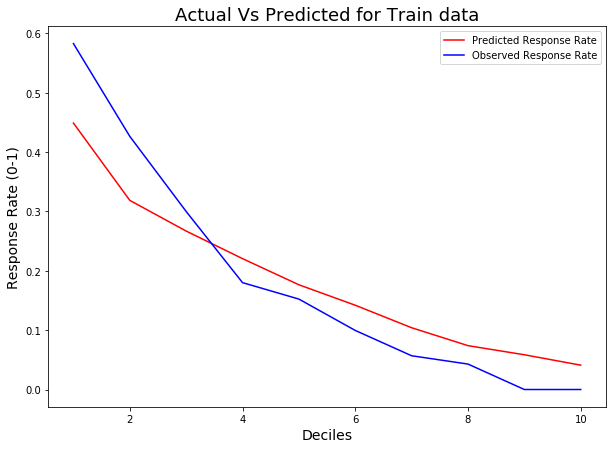

In [26]:
import matplotlib.pyplot as plt
deciles = np.arange(1,11,1)
plt.figure(figsize=(10,7))
plt.plot(deciles, KS_Train["PredRR"],'-r',label="Predicted Response Rate")
plt.plot(deciles, KS_Train["ObsRR"],'-b', label="Observed Response Rate")
plt.xlabel("Deciles", fontsize=14)
plt.ylabel("Response Rate (0-1)", fontsize=14)
plt.title("Actual Vs Predicted for Train data", fontsize=18)
plt.legend(fontsize=10)
plt.savefig("RF_Act_vs_pred_trainsample.png")
plt.show()

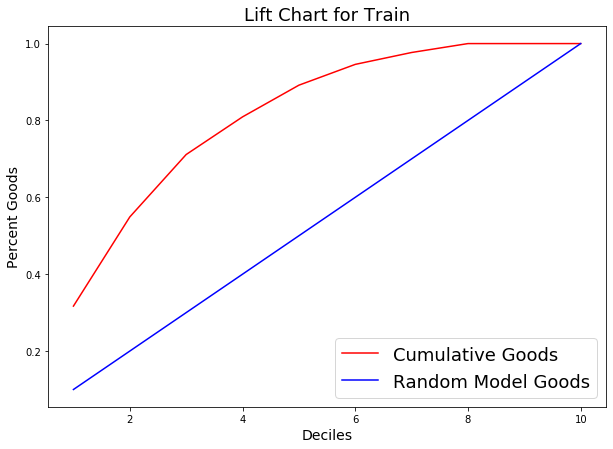

In [27]:
deciles = np.arange(1,11,1)
rand = deciles/10
plt.figure(figsize=(10,7))
plt.plot(deciles, KS_Train["Cum_Perct_Goods"],'-r',label="Cumulative Goods")
plt.plot(deciles, rand,'-b', label="Random Model Goods")
plt.xlabel("Deciles", fontsize=14)
plt.ylabel("Percent Goods", fontsize=14)
plt.title("Lift Chart for Train", fontsize=18)
plt.legend(fontsize=18)
plt.savefig("RF_lift_Chart_trainsample.png")
plt.show()

In [28]:
# Accuracy for training dataset
print ("Accuracy for training dataset is:", round(clf.score(X_train[selected_vars], y_train),2))

Accuracy for training dataset is: 0.83


### Performance for Test sample

In [29]:
y_hat = clf.predict_proba(X_test[selected_vars])
results_test = pd.DataFrame()
results_test["Prob"] = (y_hat[: ][: , 1])
results_test["y"] = y_test.ravel()

In [30]:
KS_Test = KS_Table(results_test)
print("The KS for the model is:", round(KS_Test["KS"].max(),2),"%")

The KS for the model is: 46.4 %


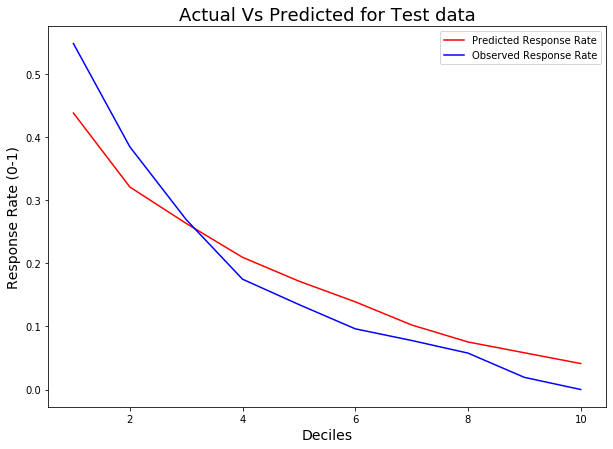

In [31]:
import matplotlib.pyplot as plt
deciles = np.arange(1,11,1)
plt.figure(figsize=(10,7))
plt.plot(deciles, KS_Test["PredRR"],'-r',label="Predicted Response Rate")
plt.plot(deciles, KS_Test["ObsRR"],'-b', label="Observed Response Rate")
plt.xlabel("Deciles", fontsize=14)
plt.ylabel("Response Rate (0-1)", fontsize=14)
plt.title("Actual Vs Predicted for Test data", fontsize=18)
plt.legend(fontsize=10)
plt.savefig("RF_Act_vs_pred_testsample.png")
plt.show()

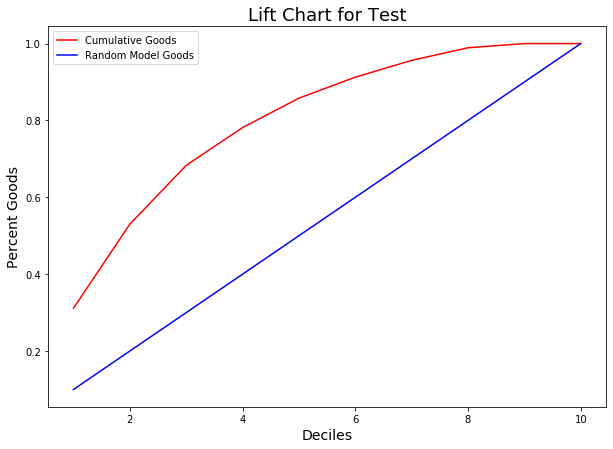

In [32]:
deciles = np.arange(1,11,1)
rand = deciles/10
plt.figure(figsize=(10,7))
plt.plot(deciles, KS_Test["Cum_Perct_Goods"],'-r',label="Cumulative Goods")
plt.plot(deciles, rand,'-b', label="Random Model Goods")
plt.xlabel("Deciles", fontsize=14)
plt.ylabel("Percent Goods", fontsize=14)
plt.title("Lift Chart for Test", fontsize=18)
plt.legend(fontsize=10)
plt.savefig("RF_lift_Chart_trainsample.png")
plt.show()

In [33]:
# Accuracy for test dataset
print ("Accuracy for training dataset is:", round(clf.score(X_test[selected_vars], y_test),2))

Accuracy for training dataset is: 0.83
